In [1]:
!git clone https://github.com/omriallouche/text_classification_from_zero_to_hero.git
import os
os.chdir('text_classification_from_zero_to_hero')

Cloning into 'text_classification_from_zero_to_hero'...
remote: Enumerating objects: 107, done.
remote: Total 107 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (107/107), 51.67 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (48/48), done.


# ULMFiT
For more information I recommend this [excellent post](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb).

UlmFit consists of 3 steps:
1. Training the language model on a general-domain corpus that captures high-level natural language features
1. Fine-tuning the pre-trained language model on target task data
1. Fine-tuning the classifier on target task data

![ulmfit 3 steps](https://miro.medium.com/max/1616/1*w_qNXVr7N2OPCK5iMnHAVQ.png)

Step 1 requires a lot of resources and was already performed by the creators of the FastAI package. For this task we will perform steps 2 and 3.

It puts together a few tricks for optimizing neural networks:
1. Detection of initial Learning Rate. This is done by changing the learning rate in a wide range during the first steps of a neural network training, and keeping the rate that leads to the fastest decrease of the network loss. 
1. Cyclical learning rate changes, that aim to improve convergence speed while reducing the risk of getting stuck in a local minimum
1. Transfer learning 
1. Integration of a large unlabeled dataset. This dataset is used to fine-tune the language model
1. A rather simple but effective network architecture for the classifier. This NN architecture of 3 fully connected layers is supposed to provide solid performance on a large array of text classification tasks

Using Ulmfit is rather simple

The Note that we provide the data to the language model 
`bs` is the batch size.  
We use the function `learner.lr_find()` to find the learning rate.  

The function `learner.fit_one_cycle(PARAMETERS)` 


In [0]:
from fastai import *
from fastai.text import *

In [3]:
import pandas as pd
import os
df_train = pd.read_csv('../data/train.csv')
df_val = pd.read_csv('../data/val.csv')
df_trn.head()

,label,text,num_chars
0,talk.politics.mideast,i understand how israel captured the teritory ...,366
1,talk.politics.guns,and im sure that is a great comfort to the wid...,298
2,rec.sport.hockey,have a look at ed belfour. belfour kicked gerr...,288
3,talk.politics.mideast,deleted its noteworthy that the posts about th...,300
4,rec.sport.baseball,"recently, i heard the red sox on wrol a spanis...",365


In [0]:
df_train = df_train[['text', 'label']]
df_val = df_val[['text', 'label']]

In [0]:
batch_size = 16
path = ''

## Fine-tuning a language model

ULMFiT allows us to fine-tune its language model. This can lead to a significant improvement if our domain is very different than what the ULMFiT language model was trained on.  
However, if our dataset is small, there's a risk of overfitting to our small dataset, with a "catastrophic forgetting" of the original language model (that generalizes better). Watch out for the difference between the train and validation loss, and make sure you don't over train the language model on your own data.

Since the 20newsgroups dataset contains posts from many other newsgroups, one idea is to train a language model on data from other categories as well. We will not take this step here, but for this you will probably want to use texts from the file `data/20newsgroups.csv`.

In [ ]:
df_lm_train = pd.read_csv('../data/20newsgroups.csv')
df_lm_valid = df_lm_all.sample(frac=0.2, random_state=0)
df_lm_train = df_lm_train.drop(df_lm_valid.index)

Let's continue with our script:

In [23]:
# Language model data
print('Getting languge model data...')
if not os.path.exists(path+'/data_lm_export.pkl'):
    data_lm = TextLMDataBunch.from_df(
        train_df=df_lm_train,
        valid_df=df_lm_valid,
        path=path, 
        label_cols='label', 
        text_cols='text')
    data_lm.save('data_lm_export.pkl')
else:
    data_lm = load_data(path, 'data_lm_export.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
data_lm.show_batch()

idx,text
0,"xxunk xxunk . i also root for frank thomas . xxbos yeah valentine , how many rings does clemens have ? xxunk like good old xxunk canadian logic . btw the only good thing i can say about the jays rotation this year is that it could have been worse . xxunk might have xxunk healthy . xxbos wetteland comes off the dl on april rd , and will be"
1,"the league . this was kind of xxunk because they won the world series both the previous year and the following year . warren xxunk xxbos these people were very xxunk . any team that gets to the world series can win the world series , and anybody who ever xxunk a sweep is xxunk . if you put the best team in baseball in the series against the worst"
2,"happens to be , well hey , the xxunk th starter . as for xxunk , its still early . xxbos discussing the fact that there were only players who had ever hit homeruns and stolen bases in their career while xxunk was batting . anyone have a list ? not as xxunk as it sounds to come up with all of them . i could nt . mays ,"
3,"kind of xxunk all season ! how many home runs by xxunk ? just , right , you must be thinking of dean palmer or juan gonzalez both of texas who each had homers . i do nt know how many to follow , but he was for . xxbos mr . hernandez i apologize for the xxunk . i xxunk that i know that it is xxunk for some"
4,". xxunk , xxunk xxunk stadium , was built years earlier . xxunk they do nt move the seats back for the few xxunk games but the xxunk lower xxunk used to move . it was all xxunk , which was pretty xxunk on bat day . its vastly better than it was before they xxunk it , though . back in the late s it was a xxunk ."


In [0]:
lm_learn = language_model_learner(
    data_lm, 
    drop_mult=0.7, 
    arch=AWD_LSTM)

# On machines that support it, you can change to float16 precision. This leads to x2-x3 speedup on modern GPUs
# lm_learn = lm_learn.to_fp16(clip=0.1)

The `fast.ai` package includes a method to find an optimal learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


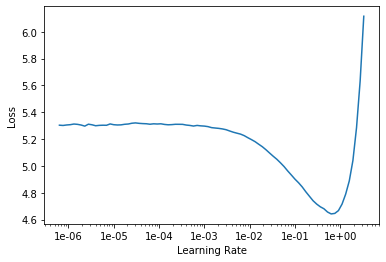

In [26]:
# Find the optimal learning rate
lm_learn.lr_find(start_lr=1e-07, end_lr=10)
# Plot a graph for detecting the optimal learning rate
lm_learn.recorder.plot()

We now can choose the learning rate from the plot above. We want a value that is a bit lower than the lowest point. 2e-1 seems to be a good value.

In [0]:
lr = 1e-2

We can test the language model by generating a few words following a seeding sentence:

In [ ]:
lm_learn.predict("The problem with this is", n_words=40)

In [39]:
# train the learner object
lm_learn.fit_one_cycle(cyc_len=1, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.334176,4.628334,0.189286,00:02


Let's check how things change after one epoch of LM training:

In [46]:
lm_learn.predict("The problem with this is", n_words=40)

'The problem with this is that local hockey is so small on my grasp that it seems that everyone else in this lineup is treated to the real abc telecast while only the people on rogers tv in on their nowhere , so what you'

Let's continue training the LM for 5 more cycles:

In [44]:
lm_learn.fit_one_cycle(cyc_len=5, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.002279,5.028047,0.202009,00:02
1,0.978512,5.148430,0.200223,00:02
2,0.888426,5.330887,0.183259,00:02
3,0.854780,5.389820,0.192522,00:02
4,0.800180,5.407240,0.187277,00:02
5,0.741526,5.373962,0.178125,00:02
6,0.688714,5.431108,0.180804,00:02
7,0.628530,5.413410,0.183705,00:02
8,0.579777,5.379051,0.181585,00:02
9,0.536121,5.373295,0.183147,00:02


In [0]:
# Save the model to disk. We will need it for the text classifier later
lm_learn.save_encoder('ft_enc')

## Training a classifier

In [48]:
if os.path.exists(path+'/data_clas.pkl'):
    data_clas = load_data(path, 'data_clas.pkl', bs=batch_size)
else:
    data_clas = TextClasDataBunch.from_df(
        path=path,
        train_df=df_trn, 
        valid_df=df_val,
        label_cols='label', 
        text_cols='text', 
        vocab=data_lm.train_ds.vocab, 
        bs=batch_size)    
    data_clas.save('data_clas.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [70]:
# 
classifier_learn = text_classifier_learner(data_clas, drop_mult=0.7, pretrained=False, arch=AWD_LSTM)
# 
classifier_learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (356 items)
x: TextList
xxbos i understand how israel xxunk the xxunk and xxunk that it is its right to annex it . i ca nt xxunk understand why it has to deal with xxunk much the same way jews were treated before the holocaust the final xxunk by xxunk . what i xxunk do nt get is why the u.s . has to xxunk the xxunk of such a xxunk xxunk of human rights . just wondering,xxbos and i m sure that is a great xxunk to the xxunk and children of those xxunk , beaten and burned to death . the real question is , did the xxunk rate in england go down , after they xxunk gun control xxunk ? if you look at the xxunk before and after their first such law in , you will see no effect .,xxbos have a look at xxunk xxunk . xxunk xxunk xxunk xxunk when the wings played the hawks a couple of xxunk ago . no penalty . no review . no xxunk . this was after he xxunk bob probert in the previous period . he was xxunk for that . xxunk xxunk . too bad he goes dow

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


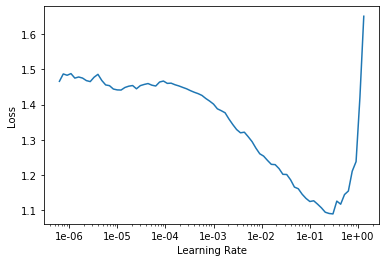

In [57]:
classifier_learn.lr_find()
classifier_learn.recorder.plot()

Let's set the learning rate based on the previous graph:

In [0]:
lr = 5e-2

In [71]:
classifier_learn.fit_one_cycle(10, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.366192,1.259665,0.434211,00:02
1,1.125656,0.879517,0.657895,00:02
2,0.949881,0.775755,0.710526,00:02
3,0.830186,0.753873,0.710526,00:02
4,0.744836,0.782417,0.657895,00:02
5,0.674462,0.812261,0.618421,00:02
6,0.601353,0.808525,0.605263,00:02
7,0.565418,0.796480,0.644737,00:02
8,0.528164,0.782703,0.644737,00:02
9,0.493174,0.786243,0.644737,00:02


We'll now gradually unfreeze the layers, starting from the top layers and adding more layers every epoch:

In [72]:
classifier_learn.freeze_to(-2)
lr /= 2
classifier_learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.462353,0.810972,0.631579,00:03


In [74]:
classifier_learn.freeze_to(-3)
lr /= 2
classifier_learn.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.276166,0.825047,0.618421,00:04
1,0.261642,0.828067,0.644737,00:04
2,0.266998,0.832981,0.657895,00:04
3,0.270807,0.826062,0.657895,00:04
4,0.255189,0.829886,0.671053,00:04
5,0.243133,0.829157,0.631579,00:04
6,0.227799,0.845982,0.644737,00:04
7,0.220496,0.837691,0.631579,00:04
8,0.215813,0.823293,0.618421,00:04
9,0.218642,0.845948,0.631579,00:04


In [64]:
classifier_learn.unfreeze()
lr /= 5
classifier_learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.535326,0.896815,0.618421,00:05
1,0.487278,0.874851,0.644737,00:05


Finally, let's save our classifier:

In [0]:
classifier_learn.save('ft_clas')

We can now make predictions:

In [0]:
pred_fwd,lbl_fwd = classifier_learn.get_preds(ordered=True)